## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [52]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [53]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes


✅ MNIST loaded: 60000 train, 10000 test images


In [54]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    "A": [0, 1],
    "B": [2, 3],
    "C": [4, 5],
    "D": [6, 7],
    "E": [8, 9],
}

#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    train_data = []
    support_data = []
    query_data = []

    class_to_indices = defaultdict(list)

    for idx in range(len(dataset)):
        _, label = dataset[idx]
        if label in task_classes:
            class_to_indices[label].append(idx)

    for cls in task_classes:
        indices = class_to_indices[cls][:]
        random.shuffle(indices)

        splits = {
            "train": indices[:n_train],
            "support": indices[n_train:n_train + n_support],
            "query": indices[n_train + n_support:n_train + n_support + n_query],
        }

        new_label = task_classes.index(cls)

        for i in splits["train"]:
            img, _ = dataset[i]
            train_data.append((img, new_label))

        for i in splits["support"]:
            img, _ = dataset[i]
            support_data.append((img, new_label))

        for i in splits["query"]:
            img, _ = dataset[i]
            query_data.append((img, new_label))

    return train_data, support_data, query_data
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets


In [55]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [56]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [57]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.data = list(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y


def train_model(model, dataloader, epochs=10, lr=1e-3):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(epochs):
        total_loss = 0.0

        for batch in dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    return losses


def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            preds = torch.argmax(model(x), dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [58]:
#Method 1 - Fully Trained Binary Classifier on Task A
train_A, support_A, query_A = create_task_datasets(
    train_dataset, task_definitions['A']
)

model_A = SimpleCNN(num_classes=2).to(device)

train_loader_A = DataLoader(
    SimpleDataset(train_A),
    batch_size=8,
    shuffle=True
)

query_loader_A = DataLoader(
    SimpleDataset(query_A),
    batch_size=8,
    shuffle=False
)

loss_A = train_model(
    model_A,
    train_loader_A,
    epochs=20
)

acc_A = evaluate_model(
    model_A,
    query_loader_A
)

print(f"Accuracy : {acc_A}")


Epoch [1/20] Loss: 0.6575
Epoch [2/20] Loss: 0.3682
Epoch [3/20] Loss: 0.1362
Epoch [4/20] Loss: 0.0354
Epoch [5/20] Loss: 0.0064
Epoch [6/20] Loss: 0.0029
Epoch [7/20] Loss: 0.0012
Epoch [8/20] Loss: 0.0003
Epoch [9/20] Loss: 0.0001
Epoch [10/20] Loss: 0.0001
Epoch [11/20] Loss: 0.0000
Epoch [12/20] Loss: 0.0000
Epoch [13/20] Loss: 0.0000
Epoch [14/20] Loss: 0.0000
Epoch [15/20] Loss: 0.0000
Epoch [16/20] Loss: 0.0000
Epoch [17/20] Loss: 0.0000
Epoch [18/20] Loss: 0.0000
Epoch [19/20] Loss: 0.0000
Epoch [20/20] Loss: 0.0000
Accuracy : 1.0


In [59]:
#Method 2 - Fine Tuning all 3 methods

#1 Randomly initialized model fine-tuned using Task A support set

model_random_A = SimpleCNN(num_classes=2).to(device)

support_loader_A = DataLoader(
    SimpleDataset(support_A),
    batch_size=4,
    shuffle=True
)

loss_rand_A = train_model(
    model_random_A,
    support_loader_A,
    epochs=10
)

acc_rand_A = evaluate_model(
    model_random_A,
    query_loader_A
)

print("(Random initialization of task A support set) Accuracy:", acc_rand_A)


Epoch [1/10] Loss: 0.6479
Epoch [2/10] Loss: 0.4188
Epoch [3/10] Loss: 0.2044
Epoch [4/10] Loss: 0.0706
Epoch [5/10] Loss: 0.0139
Epoch [6/10] Loss: 0.0039
Epoch [7/10] Loss: 0.0010
Epoch [8/10] Loss: 0.0002
Epoch [9/10] Loss: 0.0001
Epoch [10/10] Loss: 0.0000
(Random initialization of task A support set) Accuracy: 0.95


In [60]:
#2 Fine tuning on task B after training on A
model_taskA = SimpleCNN(num_classes=2).to(device)

train_model(
    model_taskA,
    train_loader_A,
    epochs=20
)

train_B, support_B, query_B = create_task_datasets(
    train_dataset,
    task_definitions['B']
)

support_loader_B = DataLoader(
    SimpleDataset(support_B),
    batch_size=4,
    shuffle=True
)

query_loader_B = DataLoader(
    SimpleDataset(query_B),
    batch_size=4,
    shuffle=False
)

loss_A_to_B = train_model(
    model_taskA,
    support_loader_B,
    epochs=10
)

acc_A_to_B = evaluate_model(
    model_taskA,
    query_loader_B
)

print("Task A → Fine-tune Task B Accuracy:", acc_A_to_B)


Epoch [1/20] Loss: 0.6652
Epoch [2/20] Loss: 0.4480
Epoch [3/20] Loss: 0.2170
Epoch [4/20] Loss: 0.0737
Epoch [5/20] Loss: 0.0223
Epoch [6/20] Loss: 0.0045
Epoch [7/20] Loss: 0.0022
Epoch [8/20] Loss: 0.0010
Epoch [9/20] Loss: 0.0004
Epoch [10/20] Loss: 0.0002
Epoch [11/20] Loss: 0.0001
Epoch [12/20] Loss: 0.0001
Epoch [13/20] Loss: 0.0001
Epoch [14/20] Loss: 0.0001
Epoch [15/20] Loss: 0.0001
Epoch [16/20] Loss: 0.0001
Epoch [17/20] Loss: 0.0000
Epoch [18/20] Loss: 0.0000
Epoch [19/20] Loss: 0.0000
Epoch [20/20] Loss: 0.0000
Epoch [1/10] Loss: 2.2164
Epoch [2/10] Loss: 1.1016
Epoch [3/10] Loss: 0.4543
Epoch [4/10] Loss: 0.0814
Epoch [5/10] Loss: 0.0919
Epoch [6/10] Loss: 0.1039
Epoch [7/10] Loss: 0.0465
Epoch [8/10] Loss: 0.0262
Epoch [9/10] Loss: 0.0267
Epoch [10/10] Loss: 0.0313
Task A → Fine-tune Task B Accuracy: 0.65


In [62]:
#3 Fine tuning on A after pretraining all digits
model_pretrain = SimpleCNN(num_classes=10).to(device)

full_train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

train_model(
    model_pretrain,
    full_train_loader,
    epochs=3
)

model_pretrain.fc_layers[-1] = nn.Linear(128, 2)
model_pretrain = model_pretrain.to(device)

loss_pretrain_A = train_model(
    model_pretrain,
    support_loader_A,
    epochs=10
)

acc_pretrain_A = evaluate_model(
    model_pretrain,
    query_loader_A
)

print("Pretrained → A Accuracy:", acc_pretrain_A)


Epoch [1/3] Loss: 0.1849
Epoch [2/3] Loss: 0.0499
Epoch [3/3] Loss: 0.0341
Epoch [1/10] Loss: 1.9652
Epoch [2/10] Loss: 0.4662
Epoch [3/10] Loss: 0.0473
Epoch [4/10] Loss: 0.0106
Epoch [5/10] Loss: 0.0029
Epoch [6/10] Loss: 0.0012
Epoch [7/10] Loss: 0.0005
Epoch [8/10] Loss: 0.0003
Epoch [9/10] Loss: 0.0002
Epoch [10/10] Loss: 0.0002
Pretrained → A Accuracy: 1.0


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

/tmp/ipython-input-3368118641.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


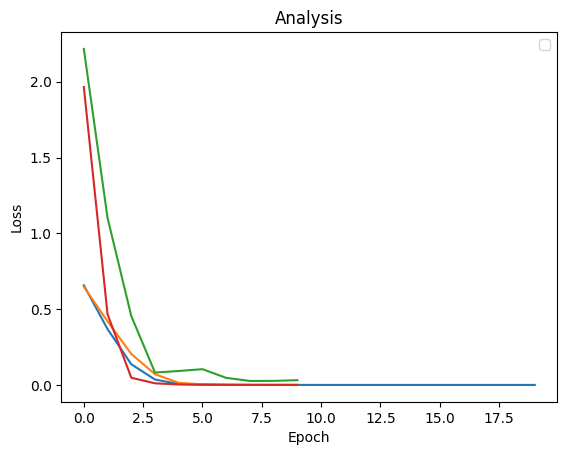

In [63]:
#Analysis and Plots
plt.plot(loss_A)
plt.plot(loss_rand_A)
plt.plot(loss_A_to_B)
plt.plot(loss_pretrain_A)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Analysis")
plt.show()


In [64]:
def compute_metrics(model, dataloader):
    model.eval()

    TP = FP = TN = FN = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)

            TP += ((preds == 1) & (y == 1)).sum().item()
            TN += ((preds == 0) & (y == 0)).sum().item()
            FP += ((preds == 1) & (y == 0)).sum().item()
            FN += ((preds == 0) & (y == 1)).sum().item()

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1


results = {}

results["Scratch Task A"] = compute_metrics(model_A, query_loader_A)
results["Random Init → Support A"] = compute_metrics(model_random_A, query_loader_A)
results["Task A → Task B"] = compute_metrics(model_taskA, query_loader_B)
results["Pretrain All → Support A"] = compute_metrics(model_pretrain, query_loader_A)

header = f"{'Method':30s} | {'Accuracy':8s} | {'Precision':9s} | {'Recall':7s} | {'F1':6s}"
print(header)
print("-" * len(header))

for method, (acc, prec, rec, f1) in results.items():
    print(
        f"{method:30s} | "
        f"{acc:.3f}     | "
        f"{prec:.3f}      | "
        f"{rec:.3f}    | "
        f"{f1:.3f}"
    )


Method                         | Accuracy | Precision | Recall  | F1    
------------------------------------------------------------------------
Scratch Task A                 | 1.000     | 1.000      | 1.000    | 1.000
Random Init → Support A        | 0.950     | 0.909      | 1.000    | 0.952
Task A → Task B                | 0.650     | 0.615      | 0.800    | 0.696
Pretrain All → Support A       | 1.000     | 1.000      | 1.000    | 1.000


Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Pretraining on all digits followed by fine tuning on the support set works best. The model learns features like edges, strokes and shapes during pretraining, which transfer well to new binary tasks.

Fine tuning mainly adapts the classifier head and slightly adjusts features, requiring fewer samples to achieve high performance.

Though the model has seen Task B during 10-class pretraining, we aim to do binary classification by fine tuning. Fine tuning reshapes the decision boundary and adjusts the learned features with the new task specific labels, rather than relearning features from scratch.

It would not work directly due to domain mismatch between digits and letters.

Meta learning is not used as such in this assignment. We have used forms of transfer learning and fine tuning only here.

Yes. MAML is based on the idea that instead of training a model to solve one specific problem, we should train it so that it can learn new problems quickly. The main goal is to make the model good at learning, not just good at one task.

In MAML, the model is trained in such a way that when it sees a new problem, it does not need a lot of data or long training. Even with just a few examples and a few training steps, the model can adapt and start performing well. This is useful when new tasks keep changing or when collecting a large dataset for every new problem is difficult.

Because of this training style, the same model can be reused for very different problems, such as recognizing digits first and then learning to recognize letters. MAML helps the model adjust quickly instead of starting from scratch each time.

# ALL THE BEST !